# Transformers for Sentiment Classification

Welcome folks!, in the current project I will show you in detail how to implement four types of well-known transformer models making use of the transformers HuggingFace library and Keras API. 

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

- 0 → Negative
- 1 → Somewhat negative
- 2 → Neutral
- 3 → Somewhat positive
- 4 → Positive

At the end of the project we will summarize and compare their performance according to our requirements and metrics. 



## Importing the required Libraries

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
#from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.initializers import Constant


import warnings
warnings.simplefilter('ignore')

## Importing the Data

In [7]:
df=pd.read_csv('train.tsv', sep='\t')
df_test=pd.read_csv('test.tsv', sep='\t')
sample_submission=pd.read_csv('sampleSubmission.csv')

Just to confirm the number of instances and features in each file:

In [8]:
df.shape, df_test.shape

((156060, 4), (66292, 3))

In [9]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


Above we can see that Phrase and Sentiment columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

In [10]:
df_test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [12]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

The dataset looks good and we now need to know how are the 5 classes distributed in the label so as to know it's balanced or not.

In [13]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

## Plotting a pie Chart

In [16]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())

In [17]:
pie1

,Sentiment
Neutral,79582
Somewhat positive,32927
Somewhat negative,27273
Positive,9206
Negative,7072


<AxesSubplot: title={'center': 'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

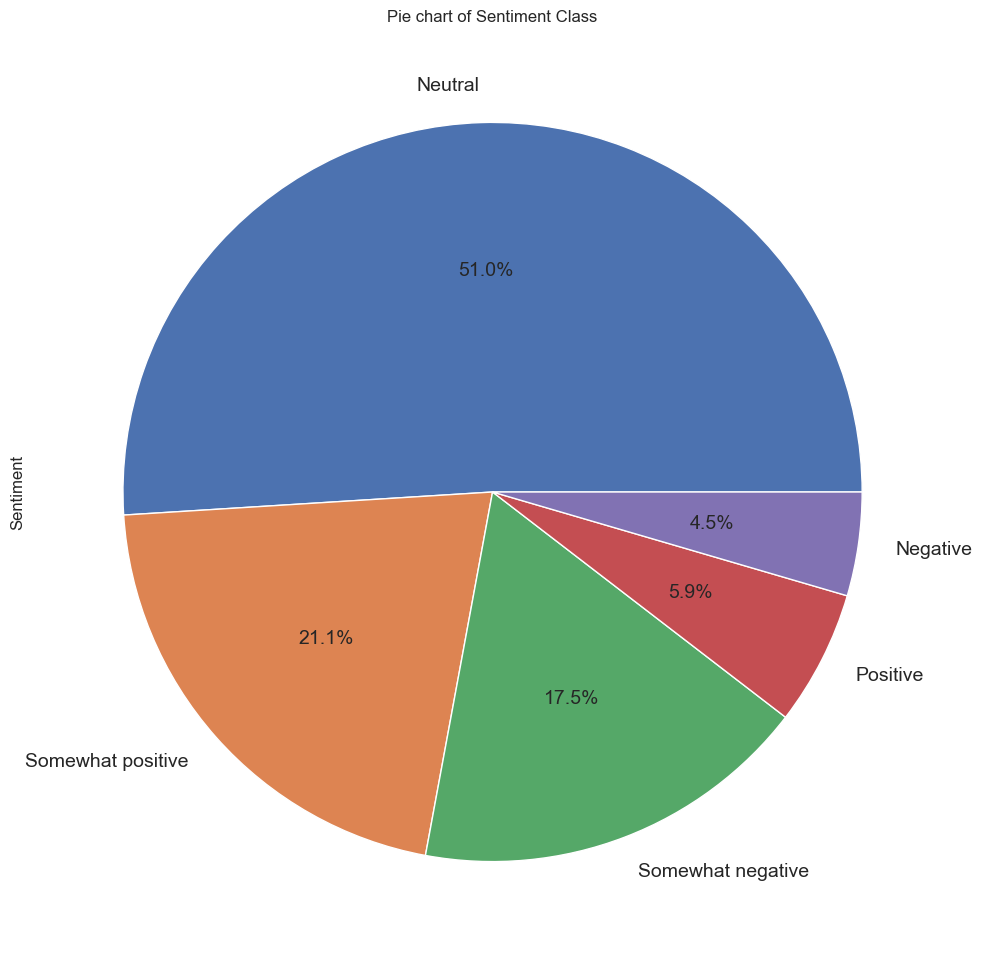

In [18]:
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

The label is considerably unbalanced, only 'Neutral' corresponds to more than 50% of instances and there is a slightly skewed towards positive reviews. Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class 

Text(0.5, 0.98, 'Histogram number of words in reviews')

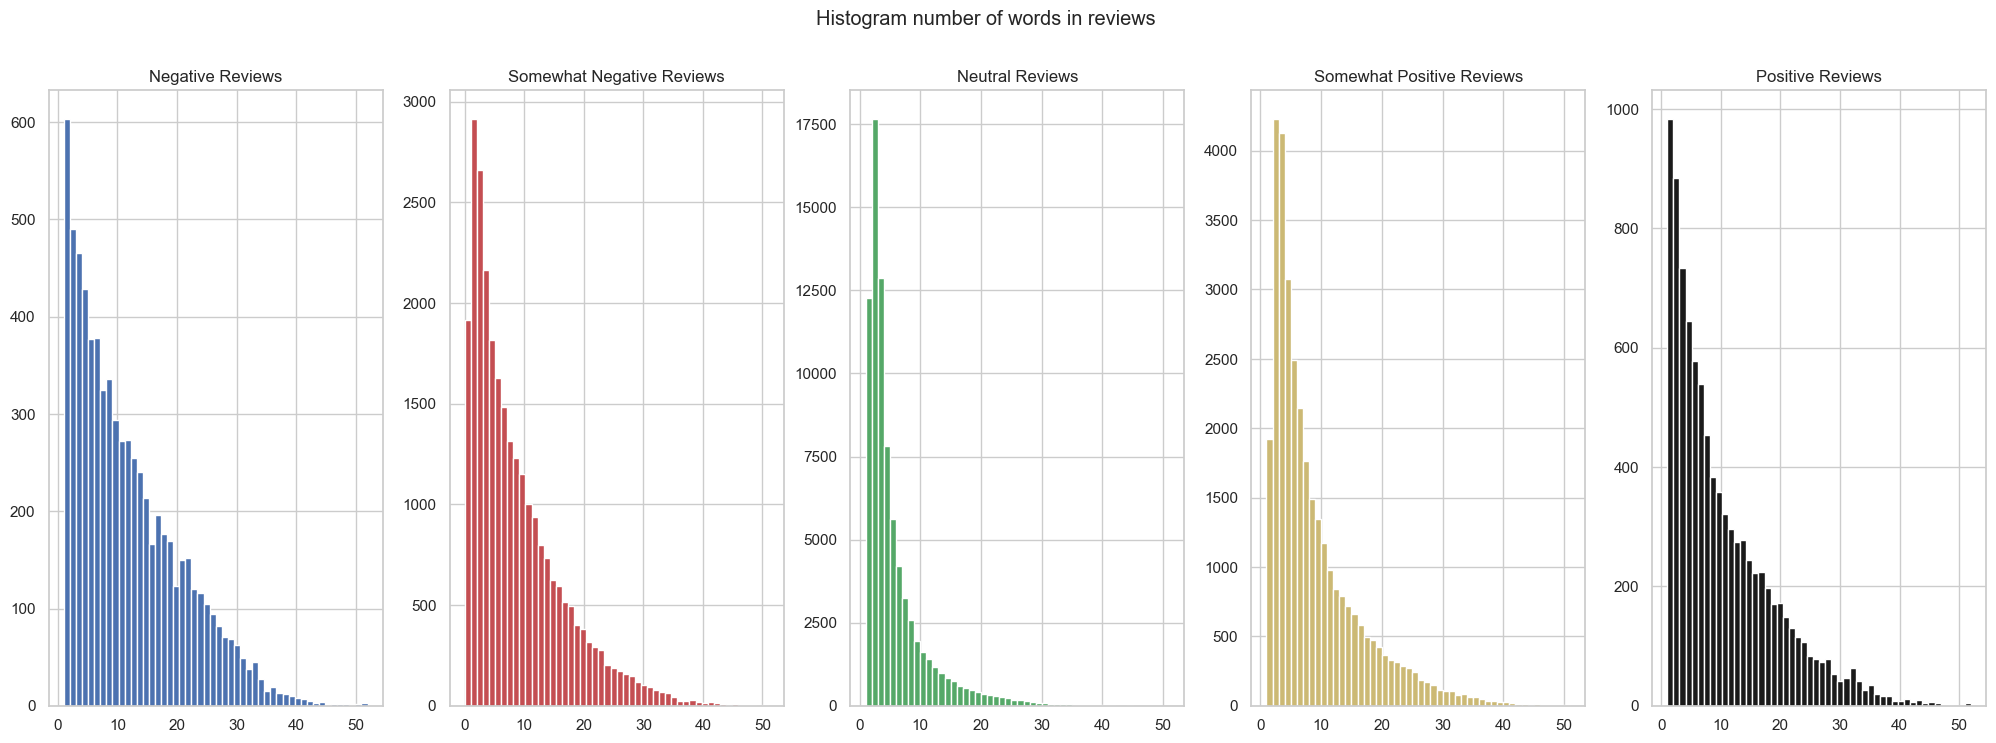

In [19]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df[df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df[df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df[df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df[df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significatively as the x-axis increases. It seems like the longest sentence in Phrase column corresponds to a class 'Negative Reviews' and is around 52 words, now let's  obtain the longest one by using the max() function: 

In [20]:
df['Phrase'].str.split().map(lambda x: len(x)).max()

52

Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [22]:
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


Above we see 352 reviews contain more than 40 words and only 18 reviews above 50 words, these two number corresponds to a tiny proportion of the total number of instances (156.060), therefore setting to these numbers will not affect too much the classification. Below we can see an example of a sentence containing 52 words, observe there are misspelled words, acronyms and some of them can be decomposed into sub-words:

In [23]:
print(df.loc[87835,'Phrase'])

There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .


# Modeling

In this step we will build, train and compare the following algorithms:

- BERT (Bidirectional Encoder Representation from Transformers)
- RoBERTa (Robustly Optimized BERT Pre-training Approach)
- DistilBERT (Distilled BERT)
- XLNet (Generalized Auto-Regressive model)

Each one of the mentioned have its pros and cons, the most preferred and widely used model is the BERT for being the middle term in performance, whereas RoBERTa and .. are known for their better error metrics and DistilBERT for its faster training. We will consider all of these chracteristics and choose the best one for our dataset.

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [24]:
#!pip install transformers

Then what we need from tensorflow.keras:

In [25]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Now we have to gather from the dataset only the two columns useful for training (Phrase and Sentiment):

In [33]:
data = df[['Phrase', 'Sentiment']]

In [34]:
data.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [35]:
# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Phrase           156060 non-null  object  
 1   Sentiment        156060 non-null  int64   
 2   Sentiment_label  156060 non-null  category
dtypes: category(1), int64(1), object(1)
memory usage: 2.5+ MB


In [38]:
# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Phrase           156060 non-null  object  
 1   Sentiment        156060 non-null  int8    
 2   Sentiment_label  156060 non-null  category
dtypes: category(1), int8(1), object(1)
memory usage: 1.5+ MB


Split into train and validation set, as the file contains more than 150 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [40]:
data_train, data_val = train_test_split(data, test_size = 0.1)

# Bert

As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model. 

In [41]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

The model we will use is 'bert_base_uncased' and the max_length chosen is 45 as there are only a very small number of larger sequences.

In [42]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)


# output_hidden_states attribute of the configuration object to False, 
# which means that the model will not return the hidden states 
# of all layers when it is run. This can be useful if you only need 
# the final output of the model and want to reduce memory usage.
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 573kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 28.0/28.0 [00:00<00:00, 9.96kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 226k/226k [00:00<00:00, 2.70MB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 455k/455k [00:00<00:00, 1.15MB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 511M/511M [00:22<00:00, 23.7MB/s]
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initi

Now that our model has been loaded we can start the processes of building and tuning according to our dataset and task using the functional API of keras.

As we see below the input layer must consider the max_length of sequences and then this is fed to the bert model, a dropout layer to reduce overfitting (0.1) and finally a dense layer with number of neurons equal to number of classes in our label (5).

In [43]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

In [48]:
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

In [49]:
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

In [53]:
# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 45)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             45, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

The next cell considers the tokenization of training and validation sentences, setting of label as categorical and finally model training.

In [23]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

2022-01-11 20:21:58.160125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
2195/2195 [==============================] - 832s 370ms/step - loss: 0.8159 - accuracy: 0.6630 - val_loss: 0.7484 - val_accuracy: 0.6882
Epoch 2/2
2195/2195 [==============================] - 808s 368ms/step - loss: 0.7143 - accuracy: 0.7029 - val_loss: 0.7432 - val_accuracy: 0.6873


The model took 27 minutes and 20 seconds to train for 2 epochs.

## Evaluate on validation set:

We will compute the error metrics on the validation set in order to have an idea of the model performance.

In [24]:
model_eval = model.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

488/488 [==============================] - 38s 78ms/step - loss: 0.7432 - accuracy: 0.6873


In [25]:
y_val_predicted = model.predict(
    x={'input_ids': x_val['input_ids']},
)

y_val_predicted corresponds to a numpy array representing the instances and the prediction as one-hot encoded, the actual label is formatted in the same manner, let's them see in detail:

In [26]:
y_val_predicted['Sentiment']

array([[-2.950402  , -0.42682916,  3.9983213 ,  0.8387285 , -2.6528964 ],
       [-0.88253033,  2.220564  ,  2.863621  , -0.81450546, -4.021455  ],
       [-3.4853635 , -0.61825454,  4.008443  ,  1.3594049 , -2.6902695 ],
       ...,
       [-0.55490416,  2.155587  ,  2.251635  , -0.6258496 , -3.6703525 ],
       [-3.4386137 , -2.891458  , -0.14394261,  3.0558197 ,  2.62261   ],
       [-1.5385206 ,  1.3927057 ,  2.3885827 ,  0.25385484, -3.1390386 ]],
      dtype=float32)

In [27]:
y_val

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In order to compute the classification report and confusion matrix we will convert the matrices to one column representing the argmax for each row:

In [28]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [29]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [30]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.47      0.51      0.49       655
           1       0.61      0.57      0.59      2942
           2       0.78      0.79      0.79      7841
           3       0.60      0.61      0.61      3229
           4       0.57      0.59      0.58       939

    accuracy                           0.69     15606
   macro avg       0.61      0.61      0.61     15606
weighted avg       0.69      0.69      0.69     15606



The fact that our dataset is unbalanced in classes makes our prediction absolutely sidetracked towards the most frequent class, in this case (2: 'Neutral'), because of this the performance of the model is poor when predicting classes 0 or 4, making our model almost unuseful for this task. Below we can see for these 2 classes the number of misclassifications is huge.

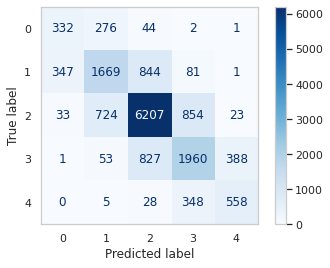

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

## Inference:

In this step we will predict the classes corresponding to the test set (out-of-bag) instances, because of the huge dataset we can expect to have almost same performance.

In [32]:
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [33]:
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [34]:
label_predicted['Sentiment']

array([[-2.6702874 , -0.08949564,  1.5939094 ,  1.6745299 , -1.6287642 ],
       [-2.7132053 , -0.10407966,  1.6614113 ,  1.7015921 , -1.6762347 ],
       [-3.3955321 , -0.5904041 ,  4.187988  ,  1.1759131 , -2.7307262 ],
       ...,
       [-0.8131799 ,  2.33063   ,  2.3363943 , -0.6862137 , -3.8018396 ],
       [-0.86436266,  2.3314843 ,  2.3517497 , -0.65539634, -3.8360848 ],
       [-0.02174537,  2.623629  ,  1.6020045 , -1.1560606 , -3.7317176 ]],
      dtype=float32)

In [35]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [37]:
label_pred_max[:10]

[3, 3, 2, 3, 3, 3, 3, 2, 3, 2]

We will build the next 3 models the same way as the previous one, notice there are some lines which includes extra functions proper for the model:

# RoBERTa

In [9]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [10]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 40

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

2022-01-11 21:10:31.557337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:10:31.558410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:10:31.559198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:10:31.560161: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


In [12]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

2022-01-11 21:12:10.718756: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
2195/2195 [==============================] - 791s 352ms/step - loss: 0.8651 - accuracy: 0.6434 - val_loss: 0.7624 - val_accuracy: 0.6776
Epoch 2/2
2195/2195 [==============================] - 769s 350ms/step - loss: 0.7511 - accuracy: 0.6880 - val_loss: 0.7460 - val_accuracy: 0.6846


The model took 26 minutes to train for 2 epochs.

## Evaluate on validation set:

In [13]:
model_eval = model2.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

488/488 [==============================] - 35s 72ms/step - loss: 0.7460 - accuracy: 0.6846


In [14]:
y_val_predicted = model2.predict(
    x={'input_ids': x_val['input_ids']},
)

In [15]:
y_val_predicted['Sentiment']

array([[ 1.3894627 ,  3.0062714 ,  1.2824216 , -1.7508354 , -3.790442  ],
       [ 0.34237924,  2.0470684 ,  1.2273293 , -0.56402296, -3.1460955 ],
       [-2.9166117 , -0.9127556 ,  0.9997995 ,  2.497976  ,  0.15765914],
       ...,
       [-3.5287771 , -0.8397119 ,  1.5419186 ,  2.628774  , -0.19562207],
       [-2.616267  , -2.3845215 , -0.33811378,  2.4585283 ,  2.941505  ],
       [ 2.3491566 ,  2.5221467 ,  0.41220522, -2.100758  , -2.8293338 ]],
      dtype=float32)

In [17]:
y_val

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [18]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [19]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       605
           1       0.60      0.58      0.59      2845
           2       0.79      0.79      0.79      8072
           3       0.55      0.60      0.57      3020
           4       0.60      0.52      0.56      1064

    accuracy                           0.68     15606
   macro avg       0.61      0.61      0.61     15606
weighted avg       0.69      0.68      0.69     15606



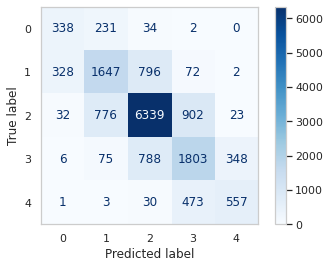

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

## Inference:

In [22]:
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [23]:
label_predicted = model2.predict(
    x={'input_ids': x_test['input_ids']},
)

In [24]:
label_predicted['Sentiment']

array([[-2.9418764 , -0.55539936,  1.7004074 ,  2.4110749 , -0.99451345],
       [-3.2369893 , -0.62712497,  1.8746588 ,  2.5353606 , -0.84780866],
       [-3.090457  , -0.12298444,  4.3306894 ,  0.86302686, -2.956068  ],
       ...,
       [-0.44193414,  2.389519  ,  2.431871  , -0.6159247 , -3.937919  ],
       [-0.49715766,  2.390551  ,  2.317669  , -0.45088452, -3.8363662 ],
       [-1.0850625 ,  2.1251652 ,  2.3940766 , -0.11107983, -3.6446486 ]],
      dtype=float32)

In [25]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [26]:
label_pred_max[:10]

[3, 3, 2, 3, 3, 3, 3, 2, 3, 2]

# DistilBERT

In [9]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 

In [10]:
### --------- Setup DistilBERT ---------- ###

model_name = 'distilbert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Distilbert model
transformer_distilbert_model = TFDistilBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-01-11 21:51:56.179200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:51:56.180259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:51:56.180890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 21:51:56.181759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

DistilBERT does not consider a pooling layer in the default model which converts the output (None,45,768) to (None,768), this is why we will select the first and third dimension of the 'layer 0' so as to have such output shape required, the next layers are the same as before:

In [11]:
### ------- Build the model ------- ###

# Load the MainLayer
distilbert = transformer_distilbert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers DistilBERT model as a layer in a Keras model
distilbert_model = distilbert(inputs)[0][:,0,:]
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(distilbert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model3 = Model(inputs=inputs, outputs=outputs, name='DistilBERT_MultiClass')

# Take a look at the model
model3.summary()

Model: "DistilBERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 66,366,725
Trainable params: 66,366,725
Non-trainable params: 0
_________________________________________________________________


In [12]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model3.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model3.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

2022-01-11 21:53:27.290563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
2195/2195 [==============================] - 424s 189ms/step - loss: 0.8222 - accuracy: 0.6601 - val_loss: 0.7735 - val_accuracy: 0.6755
Epoch 2/2
2195/2195 [==============================] - 414s 189ms/step - loss: 0.7419 - accuracy: 0.6923 - val_loss: 0.7651 - val_accuracy: 0.6786


The model took 14 minutes to train for 2 epochs.

## Evaluate on validation set:

In [13]:
model_eval = model3.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

488/488 [==============================] - 20s 40ms/step - loss: 0.7651 - accuracy: 0.6786


In [14]:
y_val_predicted = model3.predict(
    x={'input_ids': x_val['input_ids']},
)

In [15]:
y_val_predicted['Sentiment']

array([[-0.7882234 ,  2.2342474 ,  2.1206894 , -0.7060678 , -3.8744826 ],
       [-1.0700269 , -0.3415465 ,  0.16914998,  0.9569809 ,  0.05131027],
       [-3.210081  ,  0.18440111,  2.9568005 ,  1.4482275 , -2.5393188 ],
       ...,
       [-0.59788984,  2.703809  ,  2.104777  , -1.2948756 , -3.9789252 ],
       [-3.4079082 , -0.491731  ,  4.412625  ,  1.1761742 , -2.9342713 ],
       [ 2.2007382 ,  2.577497  ,  0.7560665 , -2.2572742 , -3.5935497 ]],
      dtype=float32)

In [16]:
y_val

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [17]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [18]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.36      0.58      0.44       454
           1       0.61      0.54      0.58      3099
           2       0.78      0.78      0.78      7957
           3       0.61      0.60      0.60      3248
           4       0.54      0.61      0.57       848

    accuracy                           0.68     15606
   macro avg       0.58      0.62      0.59     15606
weighted avg       0.68      0.68      0.68     15606



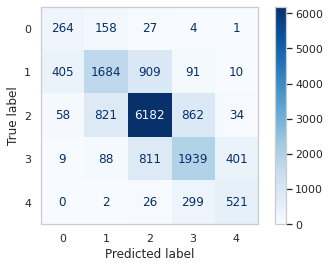

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

## Inference:

In [21]:
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [22]:
label_predicted = model3.predict(
    x={'input_ids': x_test['input_ids']},
)

In [23]:
label_predicted['Sentiment']

array([[-3.5089896 , -0.11144937,  1.2097638 ,  2.107072  , -0.86668134],
       [-3.66453   , -0.08499122,  1.456941  ,  2.1304598 , -1.1311438 ],
       [-3.4091914 , -0.7561786 ,  4.4367995 ,  1.2671455 , -3.0417826 ],
       ...,
       [-0.80668724,  2.181258  ,  2.1521475 , -0.73149747, -4.0176396 ],
       [-1.0691856 ,  2.168061  ,  2.3493197 , -0.70537597, -4.076556  ],
       [-0.29387397,  2.8122058 ,  1.8891081 , -1.3671823 , -3.9206429 ]],
      dtype=float32)

In [24]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [25]:
label_pred_max[:10]

[3, 3, 2, 3, 2, 3, 3, 2, 3, 2]

# XLNet

The tokenizer corresponding to XLNet requires an extra library called sentencepiece which we have to install and import as follows:

In [55]:
#!pip install sentencepiece 

In [54]:
from transformers import XLNetTokenizer, TFXLNetModel, XLNetConfig
import sentencepiece

In [11]:
### --------- Setup XLNet ---------- ###

model_name = 'xlnet-base-cased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = XLNetConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the XLNet model
transformer_xlnet_model = TFXLNetModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

2022-01-11 22:20:20.527193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 22:20:20.528756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 22:20:20.529753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 22:20:20.536006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Something similar to DistilBERT happens to the current model, because we have to convert the output shape of the default model first layer to the appropriate (None, 768), in this case we will use tf.squeeze function as can be seen below:

In [12]:
### ------- Build the model ------- ###

# Load the MainLayer
xlnet = transformer_xlnet_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers XLNet model as a layer in a Keras model
xlnet_model = xlnet(inputs)[0]
xlnet_model = tf.squeeze(xlnet_model[:, -1:, :], axis=1)
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(xlnet_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model4 = Model(inputs=inputs, outputs=outputs, name='XLNet_MultiClass')

# Take a look at the model
model4.summary()

Model: "XLNet_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
transformer (TFXLNetMainLaye TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 116,722,181
Trainable params: 116,722,181
Non-trainable params: 0
____________________________________

In [13]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model4.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model4.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

2022-01-11 22:21:13.767120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
2195/2195 [==============================] - 948s 424ms/step - loss: 0.8090 - accuracy: 0.6644 - val_loss: 0.7435 - val_accuracy: 0.6888
Epoch 2/2
2195/2195 [==============================] - 928s 423ms/step - loss: 0.7246 - accuracy: 0.6980 - val_loss: 0.7451 - val_accuracy: 0.6854


The model took 31 minutes and 16 seconds to train for 2 epochs.

## Evaluate on validation set:

In [14]:
model_eval = model4.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

488/488 [==============================] - 39s 80ms/step - loss: 0.7451 - accuracy: 0.6854


In [15]:
y_val_predicted = model4.predict(
    x={'input_ids': x_val['input_ids']},
)

In [16]:
y_val_predicted['Sentiment']

array([[-3.4365168 , -1.1330814 ,  1.8831319 ,  2.3386285 , -0.4450395 ],
       [-3.9699595 ,  0.32727733,  4.5337677 ,  0.9836189 , -3.807359  ],
       [-4.169939  , -3.1383638 ,  0.399411  ,  3.6032681 ,  3.6809742 ],
       ...,
       [-3.6081288 , -2.415563  ,  0.6366762 ,  2.6668108 ,  2.4975603 ],
       [ 3.6144605 ,  2.8606641 ,  0.6325866 , -2.8154707 , -4.0294094 ],
       [-2.9174604 ,  0.6392301 ,  3.0513592 ,  0.5884632 , -3.5596054 ]],
      dtype=float32)

In [17]:
y_val

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [18]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [19]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       763
           1       0.58      0.59      0.59      2672
           2       0.78      0.80      0.79      7772
           3       0.56      0.61      0.58      3048
           4       0.73      0.48      0.58      1351

    accuracy                           0.69     15606
   macro avg       0.64      0.59      0.61     15606
weighted avg       0.69      0.69      0.68     15606



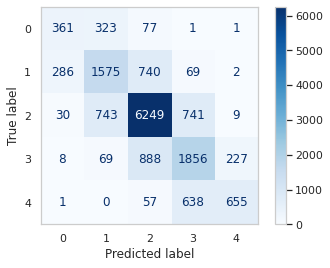

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

## Inference:

In [22]:
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [23]:
label_predicted = model4.predict(
    x={'input_ids': x_test['input_ids']},
)

In [24]:
label_predicted['Sentiment']

array([[-0.11774959,  1.8553255 ,  1.6257688 , -0.74621934, -3.8309202 ],
       [-0.87175363,  1.5396678 ,  1.7231663 , -0.14738905, -3.5544121 ],
       [-4.621074  , -0.18635918,  4.648381  ,  1.5666962 , -3.325343  ],
       ...,
       [ 0.37956503,  2.6528673 ,  1.7924142 , -1.9511659 , -4.773747  ],
       [ 0.18483469,  2.6983056 ,  1.8533108 , -1.8795936 , -4.850428  ],
       [-0.49014336,  2.3671918 ,  1.9613469 , -1.0009844 , -4.121649  ]],
      dtype=float32)

In [25]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [26]:
label_pred_max[:10]

[1, 2, 2, 2, 2, 3, 3, 2, 3, 2]

## Inference

In general the performance of the four models was similar, supporting the idea that BERT is the middle term of trade-off between accuracy and training time, whereas DistilBERT was the fastest by far, but having a lower accuracy than the previous as is explained by HuggingFace it achieves 95% accuracy of BERT, finally RoBERTa and XLNet were the models with highest accuracy and at the same time the slowest. 

The best performance was in RoBERTa reaching 68.62% of accuracy and the lowest was DistilBERT reaching 67.90%. We can say there is a slight difference but in terms of number of misclassifications the gap is huge, however the big challenge of the current task is how to deal with an unbalanced dataset, this is the main and perhaps the unique reason why we have such a poor performance even in the best one, despite the fact that increasing the max_length of sequences can increase a little bit the accuracy too, but not significatively. Maybe if we try undersampling, there will be an improvement in performance.